<a href="https://colab.research.google.com/github/Whoami666/HSE_Lab/blob/main/clean_models/schiz_models_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [10]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit-optimize

In [ ]:
!pip install catboost

In [19]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import sklearn.metrics
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

from sklearn.model_selection import KFold

In [20]:
scoring = ['recall', 'accuracy', 'f1', 'roc_auc']

In [21]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


**Non-binary**

All features

In [32]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=32)

In [33]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': [4,5,6,7,8,9, 10],
        'learning_rate' : [0.01,0.02,0.03,0.04],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train, logging_level='Silent')

BayesSearchCV(cv=3,
              estimator=<catboost.core.CatBoostClassifier object at 0x7f4a8c695070>,
              n_iter=32, scoring='f1_macro',
              search_spaces={'depth': [4, 5, 6, 7, 8, 9, 10],
                             'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                            100],
                             'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [34]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.5647020556856622
test score: 0.32569974554707376
best_params: OrderedDict([('depth', 5), ('iterations', 90), ('learning_rate', 0.04)])


In [31]:
cbc1 = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
cbc1.fit(X_train, y_train, logging_level='Silent')
y_pred = cbc1.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1

    accuracy                           0.94        51
   macro avg       0.31      0.33      0.32        51
weighted avg       0.89      0.94      0.91        51



In [35]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(cbc1, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(cbc1, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

0:	learn: 1.0651223	total: 1.51ms	remaining: 13.6ms
1:	learn: 1.0298897	total: 3.21ms	remaining: 12.9ms
2:	learn: 0.9955630	total: 4.71ms	remaining: 11ms
3:	learn: 0.9641043	total: 6.12ms	remaining: 9.18ms
4:	learn: 0.9311225	total: 7.46ms	remaining: 7.46ms
5:	learn: 0.9025311	total: 8.85ms	remaining: 5.9ms
6:	learn: 0.8791066	total: 10.3ms	remaining: 4.41ms
7:	learn: 0.8482034	total: 10.8ms	remaining: 2.71ms
8:	learn: 0.8235854	total: 12.2ms	remaining: 1.36ms
9:	learn: 0.8046338	total: 13.6ms	remaining: 0us
0:	learn: 1.0646731	total: 1.47ms	remaining: 13.2ms
1:	learn: 1.0306103	total: 2.96ms	remaining: 11.9ms
2:	learn: 0.9972932	total: 4.42ms	remaining: 10.3ms
3:	learn: 0.9702464	total: 5.8ms	remaining: 8.71ms
4:	learn: 0.9414422	total: 7.23ms	remaining: 7.23ms
5:	learn: 0.9130449	total: 8.76ms	remaining: 5.84ms
6:	learn: 0.8899619	total: 10.3ms	remaining: 4.42ms
7:	learn: 0.8593228	total: 10.9ms	remaining: 2.73ms
8:	learn: 0.8346609	total: 12.4ms	remaining: 1.38ms
9:	learn: 0.8155915

Text(0.5, 0, 'Catboost Feature Importance')

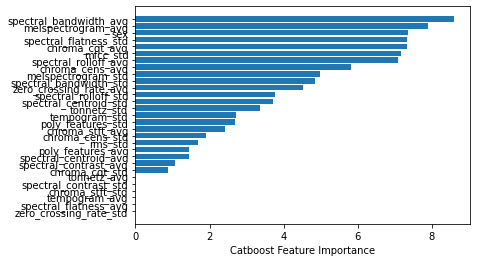

In [37]:
sorted_idx = cbc1.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], cbc1.feature_importances_[sorted_idx])
plt.xlabel("Catboost Feature Importance")


Only 1D features

In [38]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [39]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': [4,5,6,7,8,9, 10],
        'learning_rate' : [0.01,0.02,0.03,0.04],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train, logging_level='Silent')

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.4191468253968254
test score: 0.3125
best_params: OrderedDict([('depth', 9), ('iterations', 80), ('learning_rate', 0.04)])


In [40]:
cbc2 = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
cbc2.fit(X_train, y_train, logging_level='Silent')
y_pred = cbc2.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2

    accuracy                           0.88        68
   macro avg       0.29      0.33      0.31        68
weighted avg       0.78      0.88      0.83        68



In [44]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(cbc2, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(cbc2, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

0:	learn: 1.0543658	total: 6.17ms	remaining: 488ms
1:	learn: 1.0283608	total: 12.5ms	remaining: 486ms
2:	learn: 1.0032377	total: 18.5ms	remaining: 474ms
3:	learn: 0.9743333	total: 24.6ms	remaining: 468ms
4:	learn: 0.9522693	total: 30.8ms	remaining: 462ms
5:	learn: 0.9335565	total: 36.8ms	remaining: 454ms
6:	learn: 0.9100806	total: 42.7ms	remaining: 446ms
7:	learn: 0.8818131	total: 48.7ms	remaining: 438ms
8:	learn: 0.8609633	total: 54.6ms	remaining: 431ms
9:	learn: 0.8396412	total: 60.6ms	remaining: 424ms
10:	learn: 0.8248785	total: 66.4ms	remaining: 417ms
11:	learn: 0.8035575	total: 72.3ms	remaining: 410ms
12:	learn: 0.7851452	total: 78.4ms	remaining: 404ms
13:	learn: 0.7663939	total: 84.6ms	remaining: 399ms
14:	learn: 0.7498870	total: 90.6ms	remaining: 393ms
15:	learn: 0.7350713	total: 96.9ms	remaining: 387ms
16:	learn: 0.7229558	total: 103ms	remaining: 383ms
17:	learn: 0.7087715	total: 110ms	remaining: 379ms
18:	learn: 0.6958767	total: 116ms	remaining: 372ms
19:	learn: 0.6845694	tota

Text(0.5, 0, 'Random Forest Feature Importance')

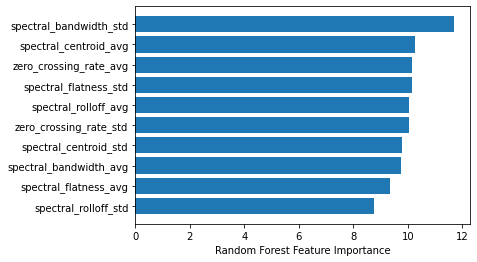

In [42]:
sorted_idx = cbc2.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], cbc2.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

**Binary**

All features

In [45]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [47]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': [4,5,6,7,8,9, 10],
        'learning_rate' : [0.01,0.02,0.03,0.04],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train, logging_level='Silent')

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.6549651567944251
test score: 0.48484848484848486
best_params: OrderedDict([('depth', 5), ('iterations', 80), ('learning_rate', 0.04)])


In [48]:
cbc3 = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
cbc3.fit(X_train, y_train, logging_level='Silent')
y_pred = cbc3.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.00      0.00      0.00         2

    accuracy                           0.94        34
   macro avg       0.47      0.50      0.48        34
weighted avg       0.89      0.94      0.91        34



In [49]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(cbc3, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(cbc3, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

0:	learn: 0.6551693	total: 1.07ms	remaining: 84.5ms
1:	learn: 0.6156858	total: 2.29ms	remaining: 89.4ms
2:	learn: 0.5779538	total: 3.4ms	remaining: 87.4ms
3:	learn: 0.5489503	total: 4.6ms	remaining: 87.3ms
4:	learn: 0.5075641	total: 5.74ms	remaining: 86.1ms
5:	learn: 0.4872492	total: 6.83ms	remaining: 84.3ms
6:	learn: 0.4595162	total: 7.92ms	remaining: 82.6ms
7:	learn: 0.4406117	total: 8.96ms	remaining: 80.7ms
8:	learn: 0.4188617	total: 10.1ms	remaining: 79.4ms
9:	learn: 0.4026387	total: 11.1ms	remaining: 77.8ms
10:	learn: 0.3818029	total: 13.1ms	remaining: 82.4ms
11:	learn: 0.3640141	total: 14.8ms	remaining: 84ms
12:	learn: 0.3471827	total: 16ms	remaining: 82.7ms
13:	learn: 0.3372030	total: 17.2ms	remaining: 81.1ms
14:	learn: 0.3223812	total: 18.3ms	remaining: 79.4ms
15:	learn: 0.3109365	total: 19.4ms	remaining: 77.8ms
16:	learn: 0.2999718	total: 20.6ms	remaining: 76.3ms
17:	learn: 0.2915004	total: 21.7ms	remaining: 74.7ms
18:	learn: 0.2829196	total: 22.8ms	remaining: 73.1ms
19:	learn

Text(0.5, 0, 'Random Forest Feature Importance')

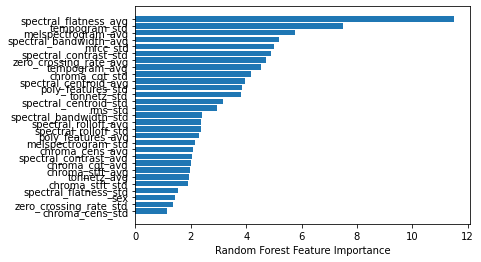

In [50]:
sorted_idx = cbc3.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], cbc3.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Only 1D features

In [51]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [52]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    CatBoostClassifier(),
    {
        'depth': [4,5,6,7,8,9, 10],
        'learning_rate' : [0.01,0.02,0.03,0.04],
        'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
    },
    n_iter=32,
    scoring='f1_macro',
    cv=3
)

opt.fit(X_train, y_train, logging_level='Silent')

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.5403769841269841
test score: 0.6761904761904762
best_params: OrderedDict([('depth', 9), ('iterations', 40), ('learning_rate', 0.04)])


In [53]:
cbc4 = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
cbc4.fit(X_train, y_train, logging_level='Silent')
y_pred = cbc4.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        60
           1       1.00      0.25      0.40         8

    accuracy                           0.91        68
   macro avg       0.95      0.62      0.68        68
weighted avg       0.92      0.91      0.89        68



In [54]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(cbc4, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(cbc4, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

0:	learn: 0.6731942	total: 2.54ms	remaining: 99.2ms
1:	learn: 0.6598975	total: 4.65ms	remaining: 88.4ms
2:	learn: 0.6511786	total: 6.96ms	remaining: 85.9ms
3:	learn: 0.6396103	total: 9.27ms	remaining: 83.5ms
4:	learn: 0.6278451	total: 11.7ms	remaining: 81.7ms
5:	learn: 0.6178355	total: 14.1ms	remaining: 79.9ms
6:	learn: 0.6074945	total: 16.4ms	remaining: 77.6ms
7:	learn: 0.5958360	total: 18.7ms	remaining: 74.9ms
8:	learn: 0.5869363	total: 21ms	remaining: 72.4ms
9:	learn: 0.5750234	total: 23.3ms	remaining: 69.8ms
10:	learn: 0.5662265	total: 25.5ms	remaining: 67.2ms
11:	learn: 0.5592856	total: 27.8ms	remaining: 64.8ms
12:	learn: 0.5498145	total: 30ms	remaining: 62.2ms
13:	learn: 0.5417313	total: 32.2ms	remaining: 59.8ms
14:	learn: 0.5350663	total: 34.3ms	remaining: 57.2ms
15:	learn: 0.5271624	total: 37.2ms	remaining: 55.8ms
16:	learn: 0.5164657	total: 40.1ms	remaining: 54.3ms
17:	learn: 0.5073496	total: 40.8ms	remaining: 49.9ms
18:	learn: 0.5003730	total: 43.2ms	remaining: 47.7ms
19:	lea

Text(0.5, 0, 'Random Forest Feature Importance')

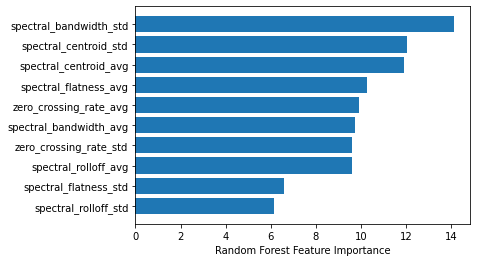

In [55]:
sorted_idx = cbc4.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], cbc4.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")